In [4]:
#to integrate R and Matlab, please use a python kernel version 3.9 or lower
#run this twice, always works the second time for some reason

import mpmath as mp
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import expm
import matlab.engine
import os
import rpy2.robjects as ro
from rpy2.robjects import default_converter, conversion
from rpy2.robjects.numpy2ri import converter as numpy_converter
import matplotlib.pyplot as plt

ro.r.source("C:/Jupyter_Notebooks/Rcode/[10]code.R")
convertTP = ro.globalenv['convertTP']


eng = matlab.engine.start_matlab()
matlab_folder = r"C:\Jupyter_Notebooks\schur-parlett_higham\include"
eng.addpath(matlab_folder, nargout=0)
version_str = eng.version()
print(version_str)

c:\Users\zacha\AppData\Local\Programs\Python\Python39\lib\site-packages\rpy2\rinterface\__init__.py:1185: UserWarning: Environment variable "PATH" redefined by R and overriding existing variable. Current: "C:\rtools45/x86_64-w64-mingw32.static.posix/bin;C:\rtools45/usr/bin;C:\Program Files\MATLAB\R2021b\extern\engines\python\..\..\..\bin\win64;c:\Users\zacha\AppData\Local\Programs\Python\Python39;c:\Users\zacha\AppData\Roaming\Python\Python39\Scripts;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Common Files\Oracle\Java\java8path;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program File

9.11.0.2358333 (R2021b) Update 7


High Precision Benchmark EXPM function,
Pade,
RK45,
SP

In [6]:


def highprec_expm(Q, prec=30):
    """
    Compute expm(Q) to 'prec' decimal places, where A is any square list-of-lists
    (or tuple-of-tuples) containing numbers that can be converted to mp.mpf.
    
    Returns an mp.matrix whose entries are mp.mpf with ~prec digits of precision.
    """
    # 1) Set mpmath's working precision
    mp.mp.dps = prec

    # 2) Convert A into an mp.matrix of mp.mpf
    n = len(Q)
    # sanity check: A must be square
    for row in Q:
        if len(row) != n:
            raise ValueError("Input must be square (n×n).")

    M = mp.matrix(n, n)
    for i in range(n):
        for j in range(n):
            M[i, j] = mp.mpf(Q[i][j])

    # 3) Compute the matrix exponential at high precision
    X = mp.expm(M)
    return X

def pade_expm(Q):
    if len(Q) != len(np.transpose(Q)) : return "error"
    return expm(Q)

def rk45_expm(Q, rtol=1e-8, atol=1e-10):
    """
    Compute the transition‐probability matrix P(t_final) for a CTMC with generator Q
    by solving the Kolmogorov forward equations dP/dt = Q·P using RK45.
    
    Parameters
    ----------
    Q : (n, n) array_like
        Generator matrix (rows sum to zero, off-diagonals ≥ 0).
    rtol : float, optional
        Relative tolerance for RK45 (passed to solve_ivp). Default is 1e-8.
    atol : float, optional
        Absolute tolerance for RK45 (passed to solve_ivp). Default is 1e-10.
    
    Returns
    -------
    P_t : (n, n) ndarray
        The transition‐probability matrix P(t_final), i.e., expm(Q·t_final) approximated
        via RK45 integration of dP/dt = Q·P, with P(0)=I.
    """
    Q = np.asarray(Q, dtype=float)
    n, m = Q.shape
    if n != m:
        raise ValueError("Generator Q must be square.")
    
    # Initial condition: P(0) = I_n, flattened to length n*n
    P0 = np.eye(n).reshape(n*n)
    
    def ode_rhs(t, P_flat):
        """
        Given flattened P (shape n*n), compute dP/dt = Q · P.
        Reshape P_flat into (n,n), multiply, then re‐flatten.
        """
        P = P_flat.reshape((n, n))
        dP = Q.dot(P)
        return dP.reshape(n*n)
    
    # Integrate from t=0 to t=t_final
    sol = solve_ivp(
        fun=ode_rhs,
        t_span=(0.0, 1.0),
        y0=P0,
        method='RK45',
        rtol=rtol,
        atol=atol
    )
    
    if not sol.success:
        raise RuntimeError(f"ODE solver failed: {sol.message}")
    
    P_t = sol.y[:, -1].reshape((n, n))
    return P_t


def schur_parl_expm(Q) : 
    Q_matlab = matlab.double(Q.tolist())
    exp_handle = eng.eval('@exp', nargout=1)
    A_matlab = eng.funm_nd(Q_matlab, exp_handle, 0.000001, nargout = 1)
    A = np.array(A_matlab)

    return A


Q Generator: 

-5 < qii < 0 (diagonal entries)
must be square
sparsity = percentage of the matrix which is 0
final column must be full of zeros for absorbing state
final row must have positive entries except for q_nn


In [8]:
import numpy as np

def Q_generator(m, sparsity, n):
    """
    Generate `n` m×m generator matrices Q where:
      - Each column j (0 ≤ j < m-1) has Q[j,j] < 0 and off‑diagonals summing to –Q[j,j].
      - Final column (j = m-1) is all zeros.
      - Final row (i = m-1) has a positive entry into every column j < m–1.
    """
    matrices = []
    for _ in range(n):
        Q = np.zeros((m, m), dtype=float)
        for j in range(m):
            # final column remains zero
            if j == m - 1:
                continue

            # diagonal entry: negative rate
            d_j = np.random.uniform(-0.05, 0.0)
            Q[j, j] = d_j

            # pick other states with some sparsity
            off_diag_inds = [i for i in range(m) if i != j]
            nonzero_inds = [i for i in off_diag_inds if np.random.rand() > sparsity]

            # if no others selected, pick one at random
            if not nonzero_inds:
                nonzero_inds = [np.random.choice(off_diag_inds)]

            # ensure final row appears in every column
            if (m - 1) not in nonzero_inds:
                nonzero_inds.append(m - 1)

            # random weights to distribute -d_j
            weights = np.random.rand(len(nonzero_inds))
            weights /= weights.sum()
            for idx, i in enumerate(nonzero_inds):
                Q[i, j] = weights[idx] * (-d_j)

        matrices.append(Q)
    return matrices


Analysis: 
-np_to_mp: helper function to convert from numpy to mpmath matrices
-mp_to_np: inversion of the former
-spectral norm: calculates the spectral norm
-fwd_err : calculates fwd error of 3 algorithms compared to highprec_expm

In [9]:
def np_to_mp(A, prec=30):
    """
    Convert a NumPy array A into an mp.matrix of mp.mpf entries
    with mp.mp.dps set to prec digits.
    """
    if isinstance(A, mp.matrix):
        return A

    mp.mp.dps = prec
    rows, cols = A.shape
    M_list = []
    for i in range(rows):
        row_list = []
        for j in range(cols):
            x = A[i, j]
            if np.iscomplexobj(A):
                # If A has complex entries, convert to mp.mpc
                row_list.append(mp.mpc(str(x.real), str(x.imag)))
            else:
                # For real/integer entries, convert to mp.mpf
                # Using str(x) preserves the decimal digits of the NumPy float
                row_list.append(mp.mpf(str(x)))
        M_list.append(row_list)

    return mp.matrix(M_list)


def mp_to_np(M):
    """
    Convert an mpmath mp.matrix M into a NumPy ndarray of floats.
    (If M has complex entries, they will become Python complex numbers.)
    """
    if isinstance(M, np.ndarray):
        return M

    nested = M.tolist()
    try:
        return np.array(nested, dtype=float)
    except (TypeError, ValueError):
        # Fall back to letting NumPy infer dtype (e.g., complex entries)
        return np.array(nested)

def spectral_norm(Q):
    """
    Compute the spectral (2‐)norm of an mpmath matrix M:
       ||M||₂ = sqrt(λ_max(M* * M)),
    where M* is the conjugate transpose of M.
    """
    M = np_to_mp(Q)
    # Form M* (conjugate transpose)
    M_star = M.H
    # Form B = M* * M, which is Hermitian (so eigenvalues are real ≥ 0)
    B = M_star * M
    # Compute all eigenvalues of B
    eigvals, _ = mp.eig(B)
    # Find the maximum absolute eigenvalue
    lam_max = max(abs(ev) for ev in eigvals)

    # The spectral norm is sqrt(lam_max)
    return mp.sqrt(lam_max)

def fwd_err(Q):
    mp_to_np(Q)
    A_highprec = highprec_expm(Q)
    A_pade = np_to_mp(pade_expm(Q))
    A_rk45 = np_to_mp(rk45_expm(Q))
    A_sp = np_to_mp(schur_parl_expm(Q))

    A_highprec_norm = spectral_norm(A_highprec)
    d_pade_norm = spectral_norm(A_pade - A_highprec)
    d_rk45_norm = spectral_norm(A_rk45 - A_highprec)
    d_sp_norm = spectral_norm(A_sp - A_highprec)

    err_pade = d_pade_norm / A_highprec_norm
    err_rk45 = d_rk45_norm / A_highprec_norm
    err_sp = d_sp_norm / A_highprec_norm

    return mp.nstr(err_pade, 5), mp.nstr(err_rk45, 5), mp.nstr(err_sp, 5)


Imports direct methods from R code: 

[10] files, R code which compares multiple methods of fractional matrix decomp of a probability transition matrix, and returns the decomposed matrix and the technique used. 

In [10]:
import numpy as np
import rpy2.robjects as ro

def translate_method(code: str) -> str:
    """
    Given a method label from convertTP (e.g., "M1", "M21", "M33"), 
    return a human-readable description of what that label means.
    """
    mapping = {
        "M1":  "Sonnenberg method",
        "M2":  "Schur-Padé method",
        "M21": "Schur-Padé with RegRE",
        "M22": "Schur-Padé with RegERE",
        "M3":  "Eigendecomposition",
        "M31": "Eigendecompositon with RegRE",
        "M32": "Eigendecomposition with RegERE",
        "M33": "direct RegQ"
    }
    return mapping.get(code, f"Unknown method code: {code}")


def P_matrix_decomp(P: np.ndarray, p: int, return_method: bool = False):

    A = mp_to_np(P)
    
    nrows, ncols = A.shape
    if nrows != ncols:
        raise ValueError(f"A must be square (n×n). Received shape: {A.shape}")
    
    A_r = ro.r.matrix(
        ro.FloatVector(A.flatten()), 
        nrow=nrows, 
        byrow=True
    )
    p_r = ro.IntVector([p])[0]
    result_r = convertTP(A_r, p_r)

    method_r = translate_method(result_r.rx2("method")[0])    
    matrix_r = result_r.rx2("matrix")          

    matrix_np = np.array(matrix_r)
    
    if return_method:
        return str(method_r)
    else:
        return matrix_np

Decomp error calculator

calculates cth decomp error (with spectral norm/with respect to highprec)

compares: 
    - pade_expm
    - rk45_expm
    - schur_parl_expm
    - direct methods


In [11]:
def decomp_err(G, p): 

    Q = mp_to_np(G)
    c = 1.0 / p 

    A = highprec_expm(Q)
    decomp_pade = np_to_mp(pade_expm(Q * c))
    decomp_rk45 = np_to_mp(rk45_expm(Q * c))
    decomp_sp = np_to_mp(schur_parl_expm(Q * c))
    decomp_10 = np_to_mp(P_matrix_decomp(A, p))

    A_pade = decomp_pade ** p 
    A_rk45 = decomp_rk45 ** p 
    A_sp = decomp_sp ** p
    A_10 = decomp_10 ** p 

    A_spec = spectral_norm(A)
    d_pade = spectral_norm(A_pade - A)
    d_rk45 = spectral_norm(A_rk45 - A)
    d_sp = spectral_norm(A_sp - A)
    d_10 = spectral_norm(A_10 - A)

    err_pade = d_pade / A_spec
    err_rk45 = d_rk45 / A_spec
    err_sp = d_sp / A_spec
    err_10 = d_10 / A_spec

    err_10_fro = np.linalg.norm(mp_to_np(A - A_10), ord='fro') / np.linalg.norm(mp_to_np(A), ord='fro')

    return mp.nstr(err_pade), mp.nstr(err_rk45), mp.nstr(err_sp), mp.nstr(err_10), P_matrix_decomp(A, p, return_method= True)


data frame saving, for use by big_Q_analysis notebook

In [5]:
import numpy as np
import pandas as pd
import mpmath as mp
import os
import pickle  # for optional use

def build_matrix_dataframe(matrix_list, output_path, matrix_file_path=None):
    """
    Process list of matrices and write a summary CSV.
    Optionally save raw matrices to a separate binary file (.npy or .pkl).
    
    Parameters
    ----------
    matrix_list : list of matrices
    output_path : str
        Path to CSV file.
    matrix_file_path : str, optional
        Path to separate file to save raw matrix list (.npy or .pkl).
    """
    records = []
    processed_matrices = []

    for idx, M_raw in enumerate(matrix_list):
        # Convert to NumPy array
        if isinstance(M_raw, mp.matrix):
            A = mp_to_np(M_raw)
        elif isinstance(M_raw, np.ndarray):
            A = M_raw
        else:
            A = np.array(M_raw)

        if A.ndim == 3 and A.shape[0] == 1 and A.shape[1] == A.shape[2]:
            A = A[0]
        if A.ndim != 2 or A.shape[0] != A.shape[1]:
            print(f"Skipping index {idx}: expected square 2D matrix, got shape {A.shape}")
            continue
        n = A.shape[0]

        # Sparsity
        total_entries = n * n
        zero_count = np.count_nonzero(A == 0)
        sparsity = zero_count / total_entries

        # Spectral norm and condition number
        try:
            spec_norm = spectral_norm(A)
        except Exception:
            spec_norm = None
        try:
            spec_cond = np.linalg.cond(A, 2)
        except Exception:
            spec_cond = None

        # Forward and decomposition errors
        try:
            fwd_tuple = fwd_err(A)
        except Exception:
            fwd_tuple = (None, None, None)
        try:
            decomp_12 = decomp_err(A, 12)
        except Exception:
            decomp_12 = (None, None, None, None, None)
        try:
            decomp_365 = decomp_err(A, 365)
        except Exception:
            decomp_365 = (None, None, None, None, None)

        records.append({
            "size": n,
            "sparsity": sparsity,
            "spectral_norm": spec_norm,
            "spectral_cond": spec_cond,
            "fwd_err": fwd_tuple,
            "decomp_err_12": decomp_12,
            "decomp_err_365": decomp_365
        })
        processed_matrices.append(A)

    # Save CSV
    df = pd.DataFrame.from_records(records)
    df.to_csv(output_path, index=False)

    # Save matrix file (optional)
    if matrix_file_path:
        ext = os.path.splitext(matrix_file_path)[1]
        if ext == ".npy":
            np.save(matrix_file_path, np.array(processed_matrices, dtype=object))
        elif ext == ".pkl":
            with open(matrix_file_path, "wb") as f:
                pickle.dump(processed_matrices, f)
        else:
            raise ValueError("matrix_file_path must end with .npy or .pkl")

    return df


Main function: tests

on standard computer, calling build_matrix_dataframe on 48000 matrices will take over 24hrs. 

In [12]:
G = np.array([
    [-0.000331941,	0.0001246943,	0.0001072461,	0.0000000000,	4.065842e-05,	5.934219e-05],
    [0.000000000,	-0.0002228618,	0.0000000000,	0.0001586238,	4.551207e-05,	1.872588e-05],
    [0.000000000,	0.0000000000,	-0.0002703439,	0.0001454130,	3.169115e-05,	9.323981e-05],
    [0.000000000,	0.0000000000,	0.0000000000,	-0.0001128961,	4.065411e-05,	7.224203e-05],
    [0.000000000,	0.0000000000,	0.0000000000,	0.0000000000,	-1.242991e-03,	1.242991e-03],
    [0.000000000,	0.0000000000,	0.0000000000,	0.0000000000,	0.000000e+00,	0.000000e+00],
], dtype=float)

G = np.transpose(G)

G = G * 365

Q_list = Q_generator(5, 0.5, 1)
print(Q_list)

for i in range (3, 51):
    print("size", i)
    for j in range(0, 101): 
        Q_list.append(Q_generator(i, np.random.uniform(low=0.1, high=0.99), 1))

#build_matrix_dataframe(Q_list, r"C:\Jupyter_Notebooks\csv files\big_Q_list.csv", matrix_file_path=r"C:\Jupyter_Notebooks\csv files\matrices.npy")


[array([[-0.03529939,  0.01441637,  0.        ,  0.        ,  0.        ],
       [ 0.01292988, -0.04147482,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.025869  ,  0.02050896,  0.        ],
       [ 0.0168448 ,  0.01162759,  0.00927617, -0.04973668,  0.        ],
       [ 0.00552471,  0.01543086,  0.01659283,  0.02922771,  0.        ]])]
size 3
size 4
size 5
size 6
size 7
size 8
size 9
size 10
size 11
size 12
size 13
size 14
size 15
size 16
size 17
size 18
size 19
size 20
size 21
size 22
size 23
size 24
size 25
size 26
size 27
size 28
size 29
size 30
size 31
size 32
size 33
size 34
size 35
size 36
size 37
size 38
size 39
size 40
size 41
size 42
size 43
size 44
size 45
size 46
size 47
size 48
size 49
size 50


calculates scaling error, but outputs in terms of a 4 part array not mpf

In [14]:
def decomp_err_raw(G, p): 

    Q = mp_to_np(G)
    c = 1.0 / p 

    A = highprec_expm(Q)

    A_spec = spectral_norm(A)
    decomp_pade = np_to_mp(pade_expm(Q * c))
    decomp_rk45 = np_to_mp(rk45_expm(Q * c))
    try: 
        decomp_sp = np_to_mp(schur_parl_expm(Q * c))
        A_sp = decomp_sp ** p
        d_sp = spectral_norm(A_sp - A)
        err_sp = d_sp / A_spec
    except: 
        err_sp = 1.0

    try:
        decomp_10 = np_to_mp(P_matrix_decomp(A, p))
        A_10 = decomp_10 ** p 
        d_10 = spectral_norm(A_10 - A)
        err_10 = d_10 / A_spec
    except: 
        err_10 = 1.0
    
    
    A_pade = decomp_pade ** p 
    A_rk45 = decomp_rk45 ** p 


    d_pade = spectral_norm(A_pade - A)
    d_rk45 = spectral_norm(A_rk45 - A)


    err_pade = d_pade / A_spec
    err_rk45 = d_rk45 / A_spec

    return err_pade, err_rk45, err_sp, err_10

'''
# Collect records
records = []
for size in range(3, 50):
    print("Processing size:", size)
    for _ in range(10):
        spars = np.random.uniform(0.1, 1.0)
        Q = Q_generator(size, spars, 1)[0]
        for j in range(1, 10):
            p = j * 1000
            err_pade, err_rk45, err_sp, err_10 = decomp_err_raw(Q, p)
            print(err_pade, err_rk45, err_sp, err_10)
            records.append({
                'size': size,
                'p': p,
                'err_pade': err_pade,
                'err_rk45': err_rk45,
                'err_sp': err_sp,
                'err_10': err_10
            })

# Build DataFrame and save
df_errs = pd.DataFrame(records)
output_csv = r"C:\Jupyter_Notebooks\csv files\decomp_errors.csv"
df_errs.to_csv(output_csv, index=False)
print(f"Saved {len(df_errs)} rows to {output_csv}")

'''



'\n# Collect records\nrecords = []\nfor size in range(3, 50):\n    print("Processing size:", size)\n    for _ in range(10):\n        spars = np.random.uniform(0.1, 1.0)\n        Q = Q_generator(size, spars, 1)[0]\n        for j in range(1, 10):\n            p = j * 1000\n            err_pade, err_rk45, err_sp, err_10 = decomp_err_raw(Q, p)\n            print(err_pade, err_rk45, err_sp, err_10)\n            records.append({\n                \'size\': size,\n                \'p\': p,\n                \'err_pade\': err_pade,\n                \'err_rk45\': err_rk45,\n                \'err_sp\': err_sp,\n                \'err_10\': err_10\n            })\n\n# Build DataFrame and save\ndf_errs = pd.DataFrame(records)\noutput_csv = r"C:\\Jupyter_Notebooks\\csv files\\decomp_errors.csv"\ndf_errs.to_csv(output_csv, index=False)\nprint(f"Saved {len(df_errs)} rows to {output_csv}")\n\n'

code to plot max p 

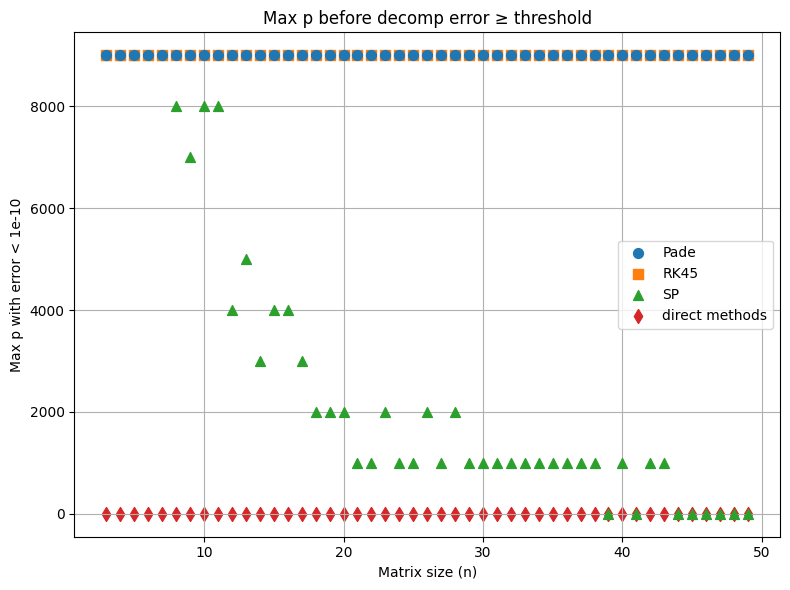

    size  err_pade  err_rk45  err_sp  err_10
0      3      9000      9000    9000       0
1      4      9000      9000    9000       0
2      5      9000      9000    9000       0
3      6      9000      9000    9000       0
4      7      9000      9000    9000       0
5      8      9000      9000    8000       0
6      9      9000      9000    7000       0
7     10      9000      9000    8000       0
8     11      9000      9000    8000       0
9     12      9000      9000    4000       0
10    13      9000      9000    5000       0
11    14      9000      9000    3000       0
12    15      9000      9000    4000       0
13    16      9000      9000    4000       0
14    17      9000      9000    3000       0
15    18      9000      9000    2000       0
16    19      9000      9000    2000       0
17    20      9000      9000    2000       0
18    21      9000      9000    1000       0
19    22      9000      9000    1000       0
20    23      9000      9000    2000       0
21    24  

In [6]:
def plot_max_p_markers_only(csv_path, threshold=1e-10, default_p=10000):
    """
    Reads the decomp_errors CSV and for each matrix size computes:
      - For Pade and RK45: max p with error < threshold, default=default_p if never crosses.
      - For SP and '10': max p with error < threshold, default=0 if never crosses.
    Excludes SP and '10' rows where error == 1.0 before filtering.
    Plots only markers (no lines), with Pade on top for visibility.
    """
    df = pd.read_csv(csv_path)
    
    methods = ['err_pade', 'err_rk45', 'err_sp', 'err_10']
    labels = {'err_pade':'Pade','err_rk45':'RK45','err_sp':'SP','err_10':'direct methods'}
    zorders = {'err_pade': 4, 'err_rk45': 3, 'err_sp': 2, 'err_10': 1}
    markers = {'err_pade': 'o', 'err_rk45': 's', 'err_sp': '^', 'err_10': 'd'}
    
    rows = []
    for size, group in df.groupby('size'):
        rec = {'size': size}
        for m in methods:
            sub = group.copy()
            # drop SP/'10' rows with error==1.0
            if m in ['err_sp', 'err_10']:
                sub = sub[sub[m] != 1.0]
            valid = sub[sub[m] < threshold]
            if not valid.empty:
                rec[m] = int(valid['p'].max())
            else:
                # default per method
                if m in ['err_pade', 'err_rk45']:
                    rec[m] = default_p
                else:
                    rec[m] = 0
        rows.append(rec)
        
    result_df = pd.DataFrame(rows).sort_values('size')
    x = result_df['size']
    
    plt.figure(figsize=(8,6))
    # scatter only, no line
    for m in methods:
        plt.scatter(
            x, result_df[m],
            marker=markers[m],
            label=labels[m],
            zorder=zorders[m],
            s=50
        )
    plt.xlabel('Matrix size (n)')
    plt.ylabel(f'Max p with error < {threshold:.0e}')
    plt.title('Max p before decomp error ≥ threshold')  # Title remains
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('max_p_markers_only.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return result_df

# Example usage:
csv_path = r"C:\Jupyter_Notebooks\csv files\decomp_errors.csv"
max_p_df = plot_max_p_markers_only(csv_path)
print(max_p_df)


Real application [27]
Generator from Ofori et al. 

In [17]:
G = np.array([
    [-0.3996,  0.00,  0.0090,  0.00,  0.00],
    [ 0.3996, -0.6335,  0.0235,  0.00,  0.00],
    [ 0.00,  0.4873, -0.7228,  0.00,  0.00],
    [ 0.00,  0.1462,  0.00, -0.7998,  0.00],
    [ 0.00,  0.00,  0.6914,  0.7998,  0.00]
])

f = fwd_err(G)
d12 = decomp_err(G, 12)
d365 = decomp_err(G, 365)
d_max = decomp_err_raw(G, 4200001)

print("forward error: ", f)
print("decomp_12 error: ", d12)
print("decomp_365 error: ", d365)
print("max decomp error: ", d_max)

forward error:  ('1.0053e-16', '1.7771e-10', '7.2415e-16')
decomp_12 error:  ('3.32803e-16', '2.24587e-11', '2.60497e-14', '1.36452', 'Schur-Padé with RegRE')
decomp_365 error:  ('1.30133e-14', '2.2116e-14', '2.81081e-13', '1.13901', 'Schur-Padé with RegRE')
max decomp error:  (mpf('0.000000000152997881239903021790261309076685'), mpf('0.000000000216029731285809432335740748498509'), 1.0, 1.0)
